In [20]:
import pandas as pd
import os
import sklearn
from sklearn.linear_model import LinearRegression
import numpy as np
from pandas_summary import DataFrameSummary
import pandas_profiling as pp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import random
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
import graphviz 
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from pandas.util import hash_pandas_object
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, StratifiedKFold, cross_val_score
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from typing import Optional, List, Any
%matplotlib inline
from IPython.core.debugger import set_trace
from dateutil.parser import parse
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder
import geopy.distance

In [2]:
train_set_df_orig = pd.read_csv("port_visits_train.csv", parse_dates = ['start_time'], date_parser = parse )
train_vessels_labels_orig = pd.read_csv("vessels_labels_train.csv", index_col='vessel_id' )

In [3]:
train_set_df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732484 entries, 0 to 732483
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   ves_id        732484 non-null  object        
 1   start_time    732484 non-null  datetime64[ns]
 2   duration_min  732484 non-null  int64         
 3   port_id       732484 non-null  object        
 4   country       732171 non-null  object        
 5   Lat           732484 non-null  float64       
 6   Long          732484 non-null  float64       
 7   port_name     732444 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 44.7+ MB


In [4]:
train_set_df_orig['type'] = train_set_df_orig['ves_id'].apply(lambda vid : 
                                    train_vessels_labels_orig.loc[vid, 'type'])
train_set_df_orig['label'] = train_set_df_orig['ves_id'].apply(lambda vid : 
                                    train_vessels_labels_orig.loc[vid, 'label'])

In [6]:
train_set_df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732484 entries, 0 to 732483
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   ves_id        732484 non-null  object        
 1   start_time    732484 non-null  datetime64[ns]
 2   duration_min  732484 non-null  int64         
 3   port_id       732484 non-null  object        
 4   country       732171 non-null  object        
 5   Lat           732484 non-null  float64       
 6   Long          732484 non-null  float64       
 7   port_name     732444 non-null  object        
 8   type          732484 non-null  object        
 9   label         732484 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 55.9+ MB


# EDA

## Initial examination of the raw data ##

### Unique vessels ###

In [7]:
uniqe_ves_ids_train_orig = np.unique(train_set_df_orig.ves_id)
len(uniqe_ves_ids_train_orig)

21122

In [8]:
len(train_vessels_labels_orig)

21642

Index(['56d8509fe4b099a29d073a62', '56d950d9e4b0e60539c6b71d',
       '56d85a07e4b0fb60063969d8', '56d85736e4b030f1c0039905',
       '56db31f9e4b02c227b748c14', '56d839f0e4b002eabab58240',
       '56dcc15fe4b009004fbe1a23', '56d96d9ee4b0515e6629201a',
       '56db8801e4b07967d3afcb96', '56d8367be4b0550004876e52',
       ...
       '56db7ddbe4b08b5ca584321a', '56dcd51be4b0a2087a7cede2',
       '56dc34b4e4b0c3380a936c08', '56d835abe4b01b88a1e19dcb',
       '56d835abe4b01b88a1e19dce', '56d83d91e4b0370600ea6b14',
       '56d98b06e4b036f77e70799a', '56d8348ee4b026569c5ac90f',
       '56d8348ee4b026569c5ac90c', '56d83d91e4b0370600ea6b19'],
      dtype='object', name='vessel_id', length=21642)

In [14]:
labels_vess_ids_intersect = set(uniqe_ves_ids_train_orig).intersection(train_vessels_labels_orig.index)
labels_vess_ids_diff = set(train_vessels_labels_orig.index ).difference(uniqe_ves_ids_train_orig)
print(f"There are {len(labels_vess_ids_intersect)} vess_ids appearing both in the train df and lables df")
print(f"There are {len(labels_vess_ids_diff)} vess_ids appearing in the lables df but not in the labels_vess_ids_diff")

There are 21122 vess_ids appearing both in the train df and lables df
There are 520 vess_ids appearing in the lables df but not in the labels_vess_ids_diff


### Unique ports ###

In [16]:
num_unique_ports_in_train = len(np.unique(train_set_df_orig.port_id.dropna()))
print(f"there are {num_unique_ports_in_train} unique ports in the train set")

there are 3590 unique ports in the train set


**The distribution of the labels is around 13.7% 1 (Tanker) and 86.3% 0 (not a tanker)**

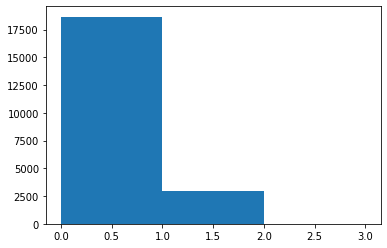

In [17]:
y_train_raw = train_vessels_labels_orig.label
counts = plt.hist(y_train_raw, bins =  [0,1,2,3] )

In [18]:
counts[0]/counts[0].sum()*100

array([86.22585713, 13.77414287,  0.        ])

### The subset of ports visited by tankers ###

In [19]:
tankers_ports_set = set(train_set_df_orig['port_id'][train_set_df_orig['label']==1])
print("There are {} ports visited by tankers, which are\
 {:0.2f}% of the overall ports".format(len(tankers_ports_set), len(tankers_ports_set)/num_unique_ports_in_train*100))

There are 1652 ports visited by tankers, which are 46.02% of the overall ports


In [20]:
all_ports_set = set(np.unique(train_set_df_orig.port_id.dropna()))
non_tanker_ports_set = set(train_set_df_orig['port_id'][train_set_df_orig['label']==0])
print("The intersection between the tankers ports and non-tanker ports is of size {} ".format(len(non_tanker_ports_set.intersection(tankers_ports_set))))

The intersection between the tankers ports and non-tanker ports is of size 1520 


## Data cleaning ##

In [21]:
#Based on https://www.marineinsight.com/guidelines/speed-of-a-ship-at-sea/
# https://en.wikipedia.org/wiki/Fishing_vessel#:~:text=The%20trolling%20line%20is%20towed,canoes%20with%20outriggers%20for%20stability.
# https://www.weeksmarine.com/equipment-division/tugboats
vess_velocities_kmph = {
    'Bulk Carrier': 15*1.852,
    'Container Vessel' : 24*1.852 , 
    'Fishing Vessel' : 11*1.852,
    'Oil Tanker': 17*1.852,
    'Passenger Vessel': 20*1.852, 
    'Reefer': 20*1.852, 
    'Tug':14*1.852
    
}

MIN_DIST_KM = 0.5

def calc_dist_km(lat_lng_1, lat_lng_2):
        return geopy.distance.geodesic(lat_lng_1, lat_lng_2).km

def calc_timediff_hours(prev_row_start_time, curr_row_start_time):
    delta = curr_row_start_time - prev_row_start_time
    return delta.days*24 + delta.seconds/3600
    
# Simplest approach - it's valid if the distance can be covered by the start times differences.
def is_valid_travel(prev_row, curr_row):
 
    if prev_row is None:
        return True, 1000000000000000 #Ideally, we won't give the first row this privilege 
    dist = calc_dist_km(prev_row[['Lat', 'Long']], curr_row[['Lat', 'Long']])
    #If we haven't moved at all - consider this as an invalid travel
    if dist <= MIN_DIST_KM:
        return False, -1
    airline_travel_duration_hours = dist/vess_velocities_kmph[curr_row['type']]
    start_times_diff_hours =  calc_timediff_hours(prev_row.start_time, curr_row.start_time )
    is_v = airline_travel_duration_hours <=  start_times_diff_hours
    max_bound = (start_times_diff_hours - airline_travel_duration_hours)*60
    return is_v, max_bound

       

def  amend_zero_durations(valid_rows: List[pd.DataFrame], idx: List[int]):
    cleaned_df = pd.DataFrame(valid_rows, index = idx)
    
    if cleaned_df['duration_min'].isnull().values.any():
        nan_entries_port_ids = set(cleaned_df['port_id'][cleaned_df['duration_min'].isnull()])
        means_per_port = {}
        grpd_by_port = cleaned_df.groupby('port_id')
        for port_id in nan_entries_port_ids:
            means_per_port[port_id] = np.nanmean(grpd_by_port.get_group(port_id).duration_min)
        for pid,pmean in means_per_port.items():
            cleaned_df.loc[(cleaned_df['port_id'] == pid) & (cleaned_df['duration_min'].isnull()),'duration_min'] = pmean
        #If we don't have the per-port - use the overall average.
        global_mean = np.nanmean(cleaned_df['duration_min'].values)
        cleaned_df.loc[cleaned_df['duration_min'].isnull(), 'duration_min'] = global_mean if not np.isnan(global_mean) else 0
    #TODO: if there's more time - use the mean over all vessels of the same type.
    return cleaned_df
        
def clean_ves_df(raw_ves_df: pd.DataFrame) -> pd.DataFrame:
    valid_rows = []
    idx = []
    prev_row = None
    #Filter out unfeasible travels
    for ind,r in raw_ves_df.sort_values(by = ['start_time']).iterrows():
     
        valid_travel, upper_duration_bound =  is_valid_travel(prev_row, r)
        if valid_travel:
            idx.append(ind)
            if len(valid_rows) > 0 :
                valid_rows[-1]['duration_min'] =  min(valid_rows[-1]['duration_min'], upper_duration_bound)
            if r['duration_min'] <= 0:
                r['duration_min'] = np.nan
            valid_rows.append(r)
            prev_row = r
        else:
            pass

    cleaned_df =  amend_zero_durations(valid_rows, idx)
    return cleaned_df

def clean_raw_port_visits(visits_df: pd.DataFrame) -> pd.DataFrame:
    cleaned_per_ves_lst = []
    for vid,ves_df in visits_df.groupby('ves_id'):
        cleaned_per_ves_lst.append(clean_ves_df(ves_df))
        print(f"finished vid {vid}")
    return pd.concat(cleaned_per_ves_lst)

In [7]:
# cleaned_raw_df = clean_raw_port_visits(train_set_df_orig)
cleaned_raw_df = pd.read_csv('training_cleaned.csv', index_col=0)

In [26]:
cleaned_raw_df.to_csv('training_cleaned.csv')

In [8]:
print(f"Before cleaning, there were overall { len(train_set_df_orig) } rows. After cleaning there are { len(cleaned_raw_df)} rows")

Before cleaning, there were overall 732484 rows. After cleaning there are 674240 rows


## Duration distribution as a function of the vessel type ##

### Durations distribution per port ###

In [9]:
train_df_to_work_with = cleaned_raw_df

There were 45 tankers visits and 589 non-tanker visits to port 5358fc78b68ca120a07dba30


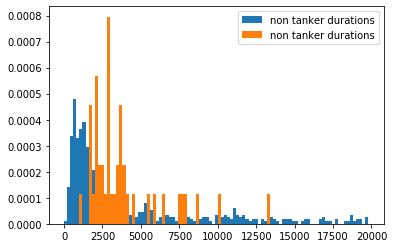

In [29]:
ports_lst = list(tankers_ports_set)
# curr_port = next(iter(tankers_ports_set))
curr_port = ports_lst[279]
curr_port_visits = train_df_to_work_with[train_df_to_work_with['port_id'] == curr_port]
curr_port_tanker_visits_durations = curr_port_visits[curr_port_visits['label']==1]['duration_min']
curr_port_non_tanker_visits_durations = curr_port_visits[curr_port_visits['label']==0]['duration_min']
print(f"There were {len(curr_port_tanker_visits_durations)} tankers visits and {len(curr_port_non_tanker_visits_durations)} non-tanker visits to port {curr_port}")
fig_visits, ax_visits = plt.subplots()
bins = np.arange(0,20000, 200)
ax_visits.hist(curr_port_non_tanker_visits_durations, bins=bins, density=True, label = "non tanker durations")
ax_visits.hist(curr_port_tanker_visits_durations,  bins=bins, density=True, label = "non tanker durations")
plt.legend()


(array([  0., 353., 183., 136., 122.,  70.,  91.,  63.,  76.,  61.,  40.,
         53.,  53.,  45.,  40.,  28.,  29.,  23.,  32.,  34.,  38.,  22.,
         24.,  30.,  22.,  14.,  20.,  23.,  21.,  27.,  19.,  21.,  26.,
         22.,  16.,  19.,  21.,  12.,  16.,  13.,  18.,  18.,  13.,   8.,
         20.,  16.,  13.,  12.,  20.,  10.,   7.,   9.,  13.,   7.,  12.,
         11.,   8.,  12.,   7.,  15.,  13.,  15.,  12.,  11.,   9.,   9.,
         11.,  10.,  15.,   4.,   8.,   5.,  10.,   9.,   7.,   4.,   8.,
          8.,   6.,   9.,   3.,   9.,   8.,   6.,   6.,   8.,   8.,   9.,
         10.,   5.,   7.,   7.,   2.,   2.,   8.,   3.,  10.,   4.,   7.,
          7.,   3.,   5.,  12.,   5.,   4.,   5.,   2.,   5.,   6.,   7.,
          6.,   5.,   2.,   4.,   5.,   8.,   2.,   5.,   2.,   4.,   5.,
          4.,   7.,   6.,   2.,   6.,   8.,   6.,   4.,   3.,   2.,   3.,
          3.,   4.,   2.,   4.,   3.,   4.,   2.,   4.,   3.,   4.,   6.,
          2.,   3.,   5.,   4.,   4., 

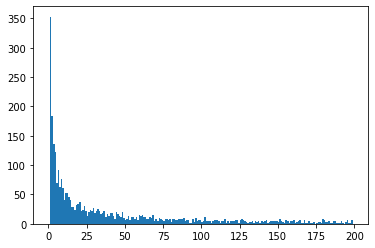

In [13]:
num_visits_per_port = [len(pdf) for pid,pdf in train_df_to_work_with.groupby('port_id')]
plt.hist(num_visits_per_port, bins=np.arange(200))

In [14]:
len(num_visits_per_port)

3586

### Durations distribution per vessel ###

In [30]:
tanker_grouped = train_df_to_work_with[train_df_to_work_with['label']==1].groupby('ves_id')
tanker_grouped_iter = iter(tanker_grouped)
non_tanker_grouped = train_df_to_work_with[train_df_to_work_with['label']==0].groupby('ves_id')
non_tanker_grouped_iter = iter(non_tanker_grouped)

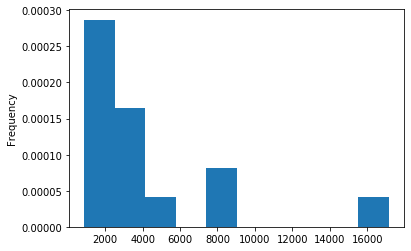

In [33]:
curr_tanker_df = next(tanker_grouped_iter)[1]
curr_tanker_df['duration_min'].plot.hist(density = True)

# non_tanker_grouped.get_group('56d8fabbe4b00724c0f7520b')['duration_min'].plot.hist()

### Durations distribution per class ###

1293.0
644.81


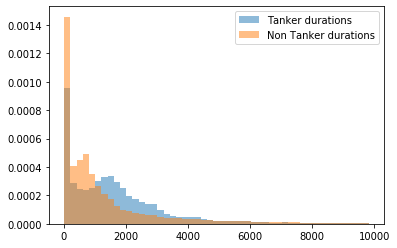

In [34]:
all_tanker_durations = train_df_to_work_with[train_df_to_work_with['label']==1]['duration_min']
all_non_tanker_durations = train_df_to_work_with[train_df_to_work_with['label']==0]['duration_min']
fig_durations,ax_durations = plt.subplots()
durations_bins = np.arange(10,10000, 200)
ax_durations.hist(all_tanker_durations, bins = durations_bins, density=True, label = 'Tanker durations', alpha=0.5)
ax_durations.hist(all_non_tanker_durations, bins = durations_bins, density=True, label = 'Non Tanker durations', alpha=0.5)
plt.legend()
print(np.median(all_tanker_durations.values))
print(np.median(all_non_tanker_durations.values))

**Num samples and overall series duration per vessel**

In [410]:
train_orig_grouped = train_df_to_work_with.groupby('ves_id')


In [36]:
per_ves_ts_len_tanker = []
per_ves_ts_duration_tanker = []
overall_deltas_tanker = np.array([])
per_ves_ts_len_non_tanker = []
per_ves_ts_duration_non_tanker = []
overall_deltas_non_tanker = np.array([])

for vid, vdf in train_orig_grouped:
#     print(vid)
    is_tanker = vdf.iloc[0]['label'] == 1
    per_ves_ts_len  = per_ves_ts_len_tanker if is_tanker else per_ves_ts_len_non_tanker
    per_ves_ts_len.append(len(vdf))
    sorted_ts = vdf['start_time'].sort_values().values
    deltas = sorted_ts[1:] - sorted_ts[:-1]
    if is_tanker:
        overall_deltas_tanker = np.append(overall_deltas_tanker, deltas.astype('timedelta64[m]').astype('int'))
    else:
        overall_deltas_non_tanker = np.append(overall_deltas_non_tanker, deltas.astype('timedelta64[m]').astype('int'))
    per_ves_ts_duration = per_ves_ts_duration_tanker if is_tanker else per_ves_ts_duration_non_tanker
    per_ves_ts_duration.append(sorted_ts[-1]-sorted_ts[0])
    

NameError: name 'train_orig_grouped' is not defined

In [289]:
overall_deltas_tanker

array([19337., 44039., 32045., ...,  2005.,  6043.,  6815.])

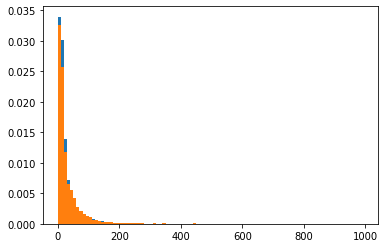

In [273]:
fig_ts_len, ax_ts_len = plt.subplots()
ax_ts_len.hist(per_ves_ts_len_tanker, bins=np.arange(0,1000,10), label='Tanker', density=True);
ax_ts_len.hist(per_ves_ts_len_non_tanker, bins=np.arange(0,1000,10), label='Non Tanker', density=True);

In [262]:
min(per_ves_ts_len)

1

In [249]:
np.array(per_ves_ts_duration).astype('timedelta64[m]').astype('int')

array([250356, 148235, 252381, ...,   1542,      0,      0])

NameError: name 'per_ves_ts_duration_non_tanker' is not defined

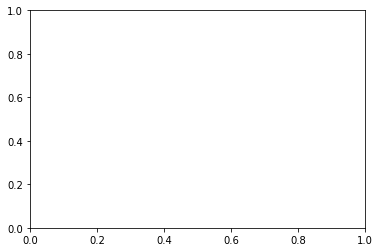

In [35]:
fig_ts_duration, ax_ts_duration = plt.subplots()
ax_ts_duration.hist(np.array(per_ves_ts_duration_non_tanker).astype('timedelta64[m]').astype('int'), label='Non Tanker', density=True, alpha=0.5);
ax_ts_duration.hist(np.array(per_ves_ts_duration_tanker).astype('timedelta64[m]').astype('int'), label='Tanker', density=True, alpha=0.5);

ax_ts_duration.legend()
# plt.hist(np.array(per_ves_ts_duration).astype('timedelta64[m]').astype('int'), density=True);

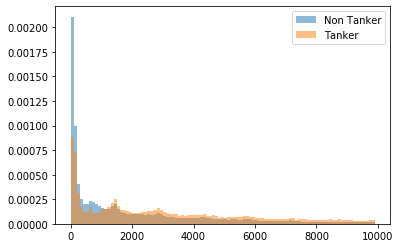

In [295]:
fig_ts_deltas, ax_ts_deltas = plt.subplots()
ax_ts_deltas.hist(overall_deltas_non_tanker,  label='Non Tanker', density=True, bins=np.arange(0,10000,100), alpha=0.5 ); 
ax_ts_deltas.hist(overall_deltas_tanker,  label='Tanker', density=True, bins=np.arange(0,10000,100), alpha=0.5 ); 
ax_ts_deltas.legend()

In [298]:
tanker_grouped_lst = list(tanker_grouped)
tanker_lst_lens = [len(vdf) for vid,vdf in tanker_grouped_lst]

In [302]:
np.argmax(tanker_lst_lens)

2741

In [300]:
len(tanker_lst_lens)

2898

In [313]:
# tanker_grouped_lst[2741][1].to_csv("tanker_2741.csv")
len(pd.unique(tanker_grouped_lst[2741][1]['port_id']))
curr_tanker_sorted_df = tanker_grouped_lst[2741][1].sort_values('start_time')
curr_tanker_sorted_df.to_csv("tanker_2741.csv")

In [316]:
non_tanker_grouped_lst = list(non_tanker_grouped)
non_tanker_lst_lens = [len(vdf) for vid,vdf in non_tanker_grouped_lst]

In [317]:
np.argmax(non_tanker_lst_lens)

9933

In [322]:
curr_non_tanker_sorted_df = non_tanker_grouped_lst[9933][1].sort_values('start_time')
curr_non_tanker_sorted_df.to_csv("non_tanker_9933.csv")

**Vess 56d96c11e4b0436ba6e245ca is a passenger vessel - it just travels between two ports: Cowes Harbour and southhampton**

In [24]:

vess_by_type = defaultdict(list)
for vid,vdf in train_orig_grouped:
    vess_by_type[vdf.iloc[0]['type']].append(vdf)



C:\Users\Matan\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\Matan\anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning:

invalid value encountered in true_divide



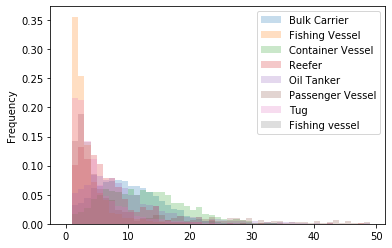

In [72]:
num_locations_per_type = { k : pd.Series( [len(np.unique(vdf['port_id'])) for vdf in vess_by_type[k]]) for k in vess_by_type}
pd.DataFrame(num_locations_per_type).plot.hist(alpha=0.25, density=True, bins=bins_for_num_locations)

In [47]:
non_tanker_num_locations = pd.Series(np.concatenate([loc_ser.values for k,loc_ser in  num_locations_per_type.items() if k != 'Oil Tanker' ]))

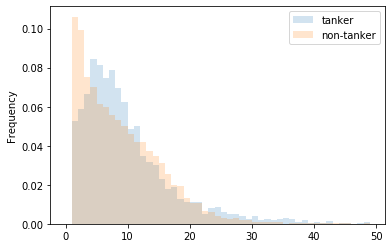

In [74]:
pd.DataFrame({"tanker": num_locations_per_type['Oil Tanker'],  "non-tanker": non_tanker_num_locations }).plot.\
hist(alpha=0.2, density=True, bins=bins_for_num_locations)

In [44]:
len(non_tanker_num_locations)

18224

In [54]:
len(non_tanker_num_locations.index.unique()) + len(num_locations_per_type['Oil Tanker'])

21122

In [53]:
sum([len(s) for s in num_locations_per_type.values() ])

21122

In [62]:
bins_for_num_locations = np.arange(0, 50, 1)

(array([0.        , 0.05248619, 0.05904696, 0.06664365, 0.08425414,
        0.08149171, 0.07458564, 0.07872928, 0.06975138, 0.0621547 ,
        0.04868785, 0.05006906, 0.03487569, 0.03176796, 0.03004144,
        0.02279006, 0.0179558 , 0.01864641, 0.01277624, 0.01104972,
        0.01139503, 0.01104972, 0.00483425, 0.00828729, 0.0086326 ,
        0.00587017, 0.00517956, 0.00517956, 0.00414365, 0.00241713,
        0.00414365, 0.00207182, 0.00241713, 0.00172652, 0.00241713,
        0.00310773, 0.00241713, 0.00069061, 0.00172652, 0.0003453 ,
        0.00069061, 0.0003453 , 0.00138122, 0.        , 0.0003453 ,
        0.0003453 , 0.        , 0.0003453 , 0.00069061]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

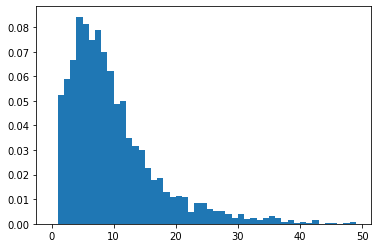

In [63]:
tanker_num_locations = [len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Oil Tanker']]
plt.hist(tanker_num_locations, density=True, bins=bins_for_num_locations)

In [38]:
passengers_num_locations = [len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Passenger Vessel']]

(array([0.        , 0.14226376, 0.18795431, 0.14018692, 0.08515057,
        0.06022845, 0.04465213, 0.04049844, 0.0238837 , 0.02076843,
        0.01973001, 0.00519211, 0.01038422, 0.00934579, 0.01557632,
        0.0145379 , 0.00726895, 0.01038422, 0.01349948, 0.00415369,
        0.00726895, 0.01142264, 0.00830737, 0.01142264, 0.00415369,
        0.00519211, 0.00934579, 0.00934579, 0.00623053, 0.00934579,
        0.00207684, 0.00623053, 0.00311526, 0.00519211, 0.00415369,
        0.00207684, 0.00311526, 0.00311526, 0.00311526, 0.00207684,
        0.00519211, 0.00207684, 0.00311526, 0.00623053, 0.00207684,
        0.00415369, 0.00103842, 0.00103842, 0.00311526]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

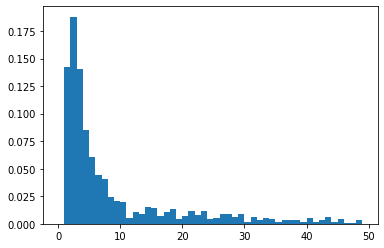

In [66]:
plt.hist(passengers_num_locations, bins=bins_for_num_locations, density=True)

(array([0.        , 0.21554661, 0.21275937, 0.14183958, 0.11117993,
        0.06720347, 0.0470734 , 0.03871168, 0.03065965, 0.02880149,
        0.01951068, 0.0142459 , 0.01238774, 0.00836172, 0.00867142,
        0.00836172, 0.00495509, 0.00495509, 0.00526479, 0.00371632,
        0.00309693, 0.00371632, 0.00185816, 0.00123877, 0.00123877,
        0.00030969, 0.00185816, 0.00061939, 0.        , 0.        ,
        0.        , 0.00030969, 0.00030969, 0.        , 0.00092908,
        0.        , 0.        , 0.        , 0.        , 0.00030969,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

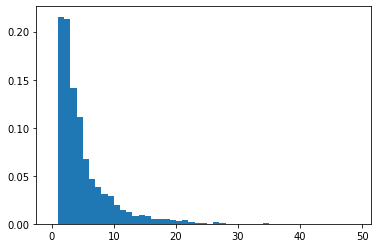

In [67]:
tug_num_locations = [len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Tug']]
plt.hist(tug_num_locations, bins=bins_for_num_locations, density=True)

(array([0.        , 0.35604607, 0.25335893, 0.13627639, 0.07101727,
        0.05278311, 0.04174664, 0.01775432, 0.01727447, 0.01007678,
        0.01007678, 0.00767754, 0.00863724, 0.00479846, 0.00239923,
        0.00431862, 0.00191939, 0.00095969, 0.00143954, 0.00095969,
        0.        , 0.        , 0.        , 0.        , 0.00047985,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

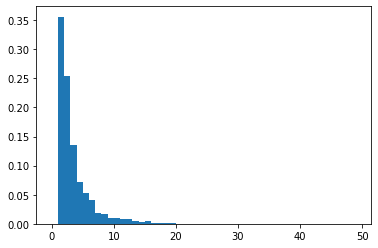

In [68]:
plt.hist([len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Fishing Vessel']], density=True, bins=bins_for_num_locations)

(array([0.        , 0.03185407, 0.0358018 , 0.04424176, 0.06180234,
        0.06452491, 0.07160359, 0.07405391, 0.07582358, 0.07391778,
        0.0649333 , 0.06575007, 0.06084944, 0.05417915, 0.04696433,
        0.03906888, 0.0319902 , 0.02613667, 0.02382249, 0.01306834,
        0.01075415, 0.00748707, 0.00558127, 0.00435611, 0.00299483,
        0.00204193, 0.00108903, 0.00081677, 0.00081677, 0.00081677,
        0.00040839, 0.00040839, 0.00054451, 0.00054451, 0.00027226,
        0.        , 0.00013613, 0.00013613, 0.        , 0.00027226,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00013613, 0.        , 0.        , 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

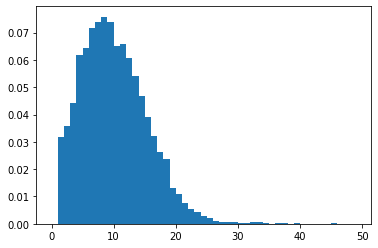

In [69]:
plt.hist([len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Bulk Carrier']], density=True, bins=bins_for_num_locations)

(array([0.        , 0.01658826, 0.02005447, 0.02698688, 0.04184204,
        0.04976479, 0.05917306, 0.05644962, 0.05471651, 0.0514979 ,
        0.06016341, 0.04926962, 0.05793513, 0.05446893, 0.05471651,
        0.05545927, 0.04976479, 0.03490963, 0.03614756, 0.03119584,
        0.02352067, 0.02822481, 0.01634068, 0.01535033, 0.01089379,
        0.0089131 , 0.00569448, 0.00866551, 0.00668482, 0.00495172,
        0.00198069, 0.0017331 , 0.00123793, 0.0017331 , 0.0017331 ,
        0.        , 0.        , 0.        , 0.00049517, 0.00024759,
        0.        , 0.00024759, 0.        , 0.        , 0.00024759,
        0.        , 0.        , 0.        , 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

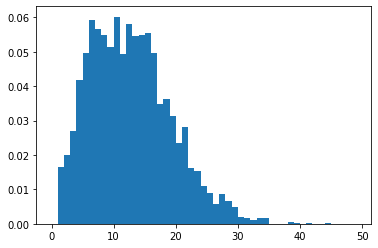

In [70]:
plt.hist([len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Container Vessel']], density=True, bins=bins_for_num_locations)

(array([0.        , 0.10153257, 0.13218391, 0.11111111, 0.11877395,
        0.10344828, 0.07854406, 0.07854406, 0.06321839, 0.04214559,
        0.02298851, 0.0210728 , 0.02873563, 0.02298851, 0.03065134,
        0.00383142, 0.00574713, 0.00383142, 0.00383142, 0.00383142,
        0.00383142, 0.00383142, 0.        , 0.00574713, 0.        ,
        0.        , 0.00191571, 0.        , 0.00191571, 0.        ,
        0.        , 0.00191571, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00191571, 0.        , 0.        ,
        0.        , 0.        , 0.00191571, 0.        ]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

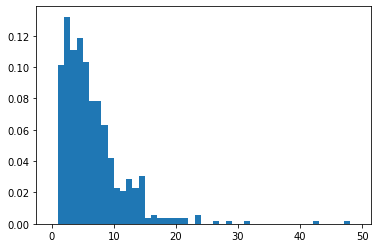

In [75]:
plt.hist([len(np.unique(vdf['port_id'])) for vdf in vess_by_type['Reefer']], density=True, bins=bins_for_num_locations)

In [13]:
np.unique(train_vessels_labels_orig.type)

array(['Bulk Carrier', 'Container Vessel', 'Fishing Vessel', 'Oil Tanker',
       'Passenger Vessel', 'Reefer', 'Tug'], dtype=object)

# Features engineering

### Extractor classes ###

In [73]:
#TODO: use ABC
class FeaturesGenerator:
    def __init__(self):
        pass
    def generate_features(self, input_df:pd.DataFrame) -> pd.DataFrame:
        pass
    
    
class LabelsGenerator:
    def __init__(self):
        pass
    def generate_labels(self, input_df:pd.DataFrame) -> pd.DataFrame:
        pass
    
    
class FeaturesExtractor:
    def __init__(self, features_generators:List[FeaturesGenerator], labels_generator: LabelsGenerator):
        self.generators_lst = features_generators
        self.labels_generator = labels_generator
    
    #Returns the features dataframe and the labels dataframe
    def generate_features(self, input_df:pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
        features_dfs = [gen.generate_features(input_df) for gen in self.generators_lst ]
        features_df = pd.concat(features_dfs, axis=1)
        labels_df = self.labels_generator.generate_labels(input_df)
        if not all(labels_df.index == features_df.index):
            raise Exception("In generate_features(). The labels and features dfs have different index!!")
        return features_df,labels_df

In [74]:
#TODO: check embedding here instead of on-hot-encoding
'''
Encode categorical ports as a one-hot numeric array, and have the per-port value the total stay duration in this port.
Return a dataframe in which each row encodes the durations per port of a single vessel.
'''
from sklearn.preprocessing import OneHotEncoder

class PortsFeaturesGenerator(FeaturesGenerator):
    def generate_features(self, input_df:pd.DataFrame) -> pd.DataFrame:
        res_df_rows = []
        res_df_ind = []
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(input_df[['port_id']])
        for vid,vdf in input_df.groupby('ves_id'):
            ports_categorized = enc.transform(vdf[['port_id']]).toarray()
            ports_categorized_durations = ports_categorized * vdf[['duration_min']].values
            res_df_ind.append(vid)
            res_df_rows.append(ports_categorized_durations.sum(axis=0))
        return pd.DataFrame(res_df_rows, index = res_df_ind, columns=enc.categories_[0])
            
'''
The spread of the visited locations
'''

class DistanceVarianceGenerator(FeaturesGenerator):
    def generate_features(self, input_df:pd.DataFrame) -> pd.DataFrame:    
        res_df_rows = []
        res_df_ind = []
        for vid,vdf in input_df.groupby('ves_id'):
            locations_polygon = Polygon([(lt,lng) for lt,lng in zip(vdf['Lat'], vdf['Long'])])
            #Probably not the geodetic centroid, but I don't have time to improve this now...
            locations_centroid = locations_polygon.centroid 
            dists_from_centroid = np.array([calc_dist_km((locations_centroid.x, locations_centroid.y), (lt,lng)) for
                                   lt,lng in zip(vdf['Lat'], vdf['Long'])] )
            res_df_ind.append(vid)
            res_df_rows.append[dists_from_centroid.dot(dists_from_centroid)/len(dists_from_centroid)]
            res =  pd.DataFrame(res_df_rows, index = res_df_ind, columns=['ports_var'])

'''
The average and median durations in the tankers and non-tanker ports 
'''
class PortsDurationSamplesFeaturesGenerator(FeaturesGenerator):
    def generate_features(self, input_df:pd.DataFrame) -> pd.DataFrame:
        all_ports_set = set(input_df['port_id'])
        tankers_ports_set = set(input_df['port_id'][input_df['label']==1])
#         non-tankers_ports_set = all_ports_set.difference(tankers_ports_set)
        res_df_rows = []
        res_df_ind = []    
        for vid,vdf in input_df.groupby('ves_id'):
            tankers_inds = vdf['port_id'].apply(lambda p : p in tankers_ports_set)
            res_df_ind.append(vid)
            res_df_rows.append([vdf[tankers_inds]['duration_min'].mean(), vdf[tankers_inds]['duration_min'].median(), 
                                vdf[~tankers_inds]['duration_min'].mean(), vdf[~tankers_inds]['duration_min'].median(), 
                               vdf['duration_min'].mean(), vdf['duration_min'].median()])
        res =  pd.DataFrame(res_df_rows, index = res_df_ind, 
                            columns=['tanker_ports_mean_duration', 'tanker_ports_median_duration', 
                                    'non_tanker_ports_mean_duration', 'non_tanker_ports_median_duration', 
                                     'all_ports_mean_duration', 'all_ports_median_duration' ])
        res = res.fillna(-1)
        return res

class PercentTankersPortsFeaturesGenerator(FeaturesGenerator):
    def generate_features(self, input_df:pd.DataFrame) -> pd.DataFrame:
        all_ports_set = set(input_df['port_id'])
        tankers_ports_set = set(input_df['port_id'][input_df['label']==1])
        res_df_rows = []
        res_df_ind = []    
        for vid,vdf in input_df.groupby('ves_id'):
            tankers_inds = vdf['port_id'].apply(lambda p : p in tankers_ports_set)
            res_df_ind.append(vid)
            res_df_rows.append([tankers_inds.sum()/len(vdf)])
                               
        res = pd.DataFrame(res_df_rows, index = res_df_ind, columns = ['tankers_ports_percentage'])
        return res
                           
    
    
class BinaryLabelsGenerator(LabelsGenerator):
    def __init__(self):
        pass
    def generate_labels(self, input_df:pd.DataFrame) -> pd.DataFrame:
        patients_classes_df = input_df.groupby('ves_id').nth(0)['label']
        return patients_classes_df
                                                                
        

In [19]:
tankers_ports_set = set(train_df_to_work_with['port_id'][train_df_to_work_with['label']==1])
print(len(tankers_ports_set))
test_grp = train_df_to_work_with.groupby('ves_id').get_group('56dd02bde4b02341a159b0ab')
test_grp

NameError: name 'train_df_to_work_with' is not defined

In [64]:
tankers_inds = test_grp['port_id'].apply(lambda p : p in tankers_ports_set)
(~tankers_inds).sum()

0

In [67]:
PortsDurationSamplesFeaturesGenerator().generate_features(test_grp)

,tanker_ports_mean_duration,tanker_ports_median_duration,non_tanker_ports_mean_duration,non_tanker_ports_median_duration,all_ports_mean_duration,all_ports_median_duration
56dd02bde4b02341a159b0ab,672.994782,300.0,-1.0,-1.0,672.994782,300.0


### Features generation ###

In [82]:
# extractor = FeaturesExtractor([PortsFeaturesGenerator()], BinaryLabelsGenerator())
extractor = FeaturesExtractor([PortsDurationSamplesFeaturesGenerator(), PercentTankersPortsFeaturesGenerator()], BinaryLabelsGenerator())
features_df, labels_df = extractor.generate_features(train_df_to_work_with)

# Classification #

## Classification utils ##

In [84]:
class ClassifierContainer:
    # Long_params_list - a wide range to examine.
    # short_params_list - reduced one based on wide range examination (to reduce runtime when executing)
    # short_params_list_over_entire_train - used for sanity tests over the entire train set before submission.
    def __init__(self, clf, long_params_list, short_params_list, short_params_list_over_entire_train):
        self.clf = clf
        self.long_params_list = long_params_list
        self.short_params_list = short_params_list
        self.short_params_list_over_entire_train = short_params_list_over_entire_train
        

        
classifiers_dict = {
    'logistic_regression': ClassifierContainer(LogisticRegression(),
                    [{'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 700, 800, 1000, 1200, 1500], 
                     'class_weight' : [None, 'balanced']}], 
                    [{'C': [ 10], 
                     'class_weight' : [ 'balanced']}], 
                    [{'C': [ 10], 
                     'class_weight' : [ 'balanced']}]
            ), 
                            
    'random_forest' : ClassifierContainer(RandomForestClassifier(), 
                           [{ 'n_estimators' : [100, 200, 500, 1000, 1200, 1500],
                              'max_depth': [ 10, 20, 30, 40, 50, 60, 100], 
                              'class_weight' :['balanced'] }
                           ], 
                            [{ 'n_estimators' : [ 500, 600],
                              'max_depth': [ 30, 40 ], 
                              'class_weight' :['balanced'] }
                           ], 
                            [{ 'n_estimators' : [ 1000, 1200],
                              'max_depth': [ 60 ], 
                              'class_weight' :['balanced'] }
                           ]
                    ),
    
    'xgboost' : ClassifierContainer( xgb.XGBClassifier(), 
                           [{ 'reg_lambda' : [10, 30, 100, 300], #[0.1, 0.3, 1, 3, 10, 30, 100, 300],
                              'max_depth': [5, 7, 10, 20, 30], #[ 10, 20, 30, 40, 50, 60, 100], 
                              'n_estimators' : [ 1000, 1500, 2000, 2500],
                              'n_jobs' : [6]
                               }
                           ], 
                             [{ 'reg_lambda' : [ 10 ],
                                'max_depth': [ 20], 
                               'n_jobs' : [6], 
                               'n_estimators' :[1500]
                               }
                           ], 
                             [{ 'reg_lambda' : [ 30 ],
                                'max_depth': [ 20], 
                               'n_jobs' : [6]
                               }
                           ]
                    ), 
#     'nn'   : ClassifierContainer( MLPClassifier(), 
#                            [{ 'hidden_layer_sizes' : [(100, 15), (500, 150), (1000, 300), (3500, 700)], 
#                               'alpha' : [0.00001, 0.00003, 0.001, 0.003, 0.1, 0.3, 1, 3, 10, 30, 100, 300]
#                                }
#                            ], 
#                              [{ 'hidden_layer_sizes' : [(1000, 300)], 
#                               'alpha' : [ 0.003]
#                                }
#                            ], 
#                              [{ 'hidden_layer_sizes' : [(1000, 300)], 
#                               'alpha' : [ 0.003]
#                                }
#                            ]
#                     )
         
}



In [85]:
def my_custom_loss_func(y_true, y_pred):
    return sklearn.metrics.f1_score(y_true, y_pred, average=None).min()

score_min_f1 = make_scorer(my_custom_loss_func, greater_is_better=True)
    
def find_optimal_meta_parameters(train_x, train_y, classifier, tuned_parameters_dict, score='f1'):
   
#!!!TODO: fix this code, in particular - the scoring!!

    scores = [score]
    for score in scores:
        print("# Tuning hyper-parameters for %s" % "min_f1")
        print()
#         cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
        cv = StratifiedKFold(n_splits=5)
        clf = GridSearchCV( #RandomizedSearchCV( # GridSearchCV(
            classifier, tuned_parameters_dict, scoring='%s_macro' % score, #score_min_f1,
            verbose=10, 
            n_jobs=6, cv =cv
        )
        clf.fit(train_x, train_y)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    return clf.best_estimator_


In [86]:
##!!!!!! removed the _dropped !!!
X_train, X_test, y_train, y_test = train_test_split(features_df, labels_df, test_size = 0.2)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

,5358fc77b68ca120a07dab3a,5358fc77b68ca120a07dab3c,5358fc77b68ca120a07dab42,5358fc77b68ca120a07dab44,5358fc77b68ca120a07dab45,5358fc77b68ca120a07dab53,5358fc77b68ca120a07dab58,5358fc77b68ca120a07dab5a,5358fc77b68ca120a07dab61,5358fc77b68ca120a07dab62,...,57d5268a376b25d85e8577d9,57d5300d8f3ea8dd5e7e5995,57d530a5376b25d85e8577e3,57d531d4be57e5de5e75ff1e,57d536d2376b25d85e8577e9,57d53f2f2e4e5fe35e7b30e5,57d5408b2e4e5fe35e7b30e9,57d543d0be57e5de5e75ff33,57d547ab8f3ea8dd5e7e59a6,57d552ff376b25d85e8577ff
56d83489e4b01c7098934f48,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
56d83489e4b01c7098934f4f,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
56d83489e4b01c7098934f50,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
56d83489e4b01c7098934f51,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
56d83489e4b025a920ad5e6e,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57722a948f0c6d34c1dabec4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5773709693808d549f0aeeda,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5773a2b72ba52333810dc7b8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5773ce253e747804ba9438fa,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [88]:
# Tune each of the considered classifiers, and store the one with highest performance in tuned_classifiers
list_to_tune_options = ['long', 'short', 'short_on_all']
list_to_tune = 'long'
classifier_dict_to_use = classifiers_dict #classifiers_dict_smote_pipeline
tuned_classifiers = {}

train_X = X_train_scaled
train_y = y_train

for clfname in classifier_dict_to_use:
    print( "\n ############## Tuning meta parameters for classifier {} ########### \n".format(clfname))
    clf_params_to_tune = classifier_dict_to_use[clfname]
    if list_to_tune == 'long':
        params_to_tune = clf_params_to_tune.long_params_list
    elif list_to_tune == 'short':
        params_to_tune = clf_params_to_tune.short_params_list
    elif list_to_tune == 'short_on_all':
        params_to_tune = clf_params_to_tune.short_params_list_over_entire_train
    else:
        print("list_to_tune {} is not valid!".format(list_to_tune))
         
    curr_best_estimator = find_optimal_meta_parameters(train_X, train_y , clf_params_to_tune.clf, 
                                 params_to_tune ,
                                 score='f1')
    tuned_classifiers[clfname] = curr_best_estimator




 ############## Tuning meta parameters for classifier random_forest ########### 

# Tuning hyper-parameters for min_f1

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    6.6s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   17.9s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   41.3s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed: 10.4min
[Parallel(

Best parameters set found on development set:

{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 100}

Grid scores on development set:

0.739 (+/-0.014) for {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 100}
0.738 (+/-0.009) for {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 200}
0.738 (+/-0.013) for {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 500}
0.738 (+/-0.011) for {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 1000}
0.738 (+/-0.012) for {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 1200}
0.737 (+/-0.011) for {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 1500}
0.736 (+/-0.015) for {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 100}
0.736 (+/-0.014) for {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 200}
0.735 (+/-0.015) for {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 500}
0.737 (+/-0.015) for {'class_weight': 'balanced', 'max_de

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   28.0s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   28.8s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed: 10.5min


KeyboardInterrupt: 

In [ ]:
x=2

# Some experiments #

In [16]:
import gmplot

# Create the map plotter:
apikey = '' # (your API key here)
gmap = gmplot.GoogleMapPlotter(37.766956, -122.448481, 14, apikey=apikey)

# Mark a hidden gem:
gmap.marker(37.770776, -122.461689, color='cornflowerblue')

# Highlight some attractions:
attractions_lats, attractions_lngs = zip(*[
    (37.769901, -122.498331),
    (37.768645, -122.475328),
    (37.771478, -122.468677),
    (37.769867, -122.466102),
    (37.767187, -122.467496),
    (37.770104, -122.470436)
])
gmap.scatter(attractions_lats, attractions_lngs, color='#3B0B39', size=40, marker=False)

# Outline the Golden Gate Park:
golden_gate_park = zip(*[
    (37.771269, -122.511015),
    (37.773495, -122.464830),
    (37.774797, -122.454538),
    (37.771988, -122.454018),
    (37.773646, -122.440979),
    (37.772742, -122.440797),
    (37.771096, -122.453889),
    (37.768669, -122.453518),
    (37.766227, -122.460213),
    (37.764028, -122.510347)
])
gmap.polygon(*golden_gate_park, color='cornflowerblue', edge_width=10)

# Draw the map to an HTML file:
gmap.draw('map.html')

In [194]:
import geopy.distance

coords_1 = (17.692, 83.28)
coords_2 = (16.978, 82.279)

print(geopy.distance.geodesic(coords_1, coords_2).km)

132.53385211071947


In [207]:
import gmplot

# Create the map plotter:
apikey = '' # (your API key here)
gmap = gmplot.GoogleMapPlotter(17.69, 83.28, 2, apikey=apikey)

test_grp = train_set_df_orig.groupby('ves_id').get_group('56dd02bde4b02341a159b0ab')
gmap.polygon(test_grp['Lat'].values, test_grp['Long'].values, color='cornflowerblue', edge_width=2)
gmap.draw('map_vss.html')

In [210]:
import gmaps
# gmaps.configure(api_key='AIza...')

fig = gmaps.figure(center=(51.5, 0.1), zoom_level=9)

# Features to draw on the map
gmt_meridian = gmaps.Line(
    start=(52.0, 0.0),
    end=(50.0, 0.0),
    stroke_weight=3.0
)
greenwich = gmaps.Marker((51.3, 0.0), info_box_content='Greenwich')

drawing = gmaps.drawing_layer(features=[greenwich, gmt_meridian])
fig.add_layer(drawing)
fig
plt.show()

In [214]:
# import gmplot package
import gmplot
#Set different latitude and longitude points
Charminar_top_attraction_lats, Charminar_top_attraction_lons = test_grp['Lat'].values, test_grp['Long'].values
# zip(*[
#    (17.3833, 78.4011),(17.4239, 78.4738),(17.3713, 78.4804),(17.3616, 78.4747),
#    (17.3578, 78.4717),(17.3604, 78.4736),(17.2543, 78.6808),(17.4062, 78.4691),
#    (17.3950, 78.3968),(17.3587, 78.2988),(17.4156, 78.4750)])
#declare the center of the map, and how much we want the map zoomed in
gmap3 = gmplot.GoogleMapPlotter(17.3616, 78.4747, 13)
# Scatter map
gmap3.scatter( Charminar_top_attraction_lats, Charminar_top_attraction_lons, '#FF0000',size = 50, marker = False )
# Plot method Draw a line in between given coordinates
gmap3.plot(Charminar_top_attraction_lats, Charminar_top_attraction_lons, 'cornflowerblue', edge_width = 3.0)
#Your Google_API_Key
# gmap.apikey = " API_Key”
# save it to html
gmap3.draw(r"scatter_1.html")

In [17]:
import os
os.system('map.html')

0

In [14]:
#Plot a vessel timeseries
def plot_vessel_timeline(vessel_id, extracted_features = None, plot_ax = None):
    if plot_ax is None:
        fig_p, ax_p = plt.subplots()
    else:
        ax_p = plot_ax
    
    curr_patient_df = train_orig_grouped.get_group(vessel_id)
    first_timestamp = curr_patient_df['timestamp'].iloc[0]
    curr_patient_df.index = list(map(lambda ts : (ts -first_timestamp).total_seconds()*1000, curr_patient_df['timestamp']))
    curr_patient_df[['measurement_x', 'measurement_y', 'measurement_z']].plot(ax=ax_p)
    if extracted_features is not None:
        coefs = extracted_features[:9].reshape(3,3).T
        x_regr = curr_patient_df.index.values
        x_mat = np.array([np.ones(len(x_regr)), x_regr, x_regr*x_regr ]).T
        curr_patient_df_approx = pd.DataFrame( x_mat.dot(coefs), 
                                              columns = ['measurement_x_regr', 'measurement_y_regr', 'measurement_z_regr'], 
                                                index = curr_patient_df.index
                                             )
        curr_patient_df_approx[['measurement_x_regr', 'measurement_y_regr', 'measurement_z_regr']].plot(ax=ax_p, style='--')
    ax_p.set_title(f"Patient {patient_id} timeseries")
    ax_p.set_xlabel("time from first timestamp (ms)")
    return len(curr_patient_df), ax_p


In [15]:
def extract_time_series

#Converts the 
def extract_features(in_df: pd.DataFrame) -> pd.DataFrame:
    #TODO: input sanity checks   
    X = []
    y = []
    iter_over = in_dfs.groupby('patient_id') if type(in_dfs) ==  pd.DataFrame else in_dfs
    for _,patient_df in iter_over:
        extracted_features = extract_single_patient_features( patient_df, extraction_scheme, ts_handling_scheme, add_avg_dists )
     
#         print(f"Appending features of shape {extracted_features.shape}")
        X.append(extracted_features )
#         print(np.array(X).shape)
#         if len(X) == 388:
#             set_trace()
        if 'label' in patient_df:
            y.append(patient_df['label'].iloc[0])
    features_names = ['meas_{}_a{}'.format(i,j) for i in ['x', 'y', 'z'] for j in range(3)]
    intersection_names = ['intersect_x_y_1', 'intersect_x_y_2', 'intersect_x_z_1', 'intersect_x_z_2',  'intersect_y_z_1', 'intersect_y_z_2']
    avg_dist_names = ['avg_dist_x_y', 'avg_dist_x_z', 'avg_dist_y_z']
    
    all_features_names = features_names + intersection_names
    if add_avg_dists:
        all_features_names += avg_dist_names
    
    return np.array(X), np.array(y),  all_features_names

SyntaxError: invalid syntax (<ipython-input-15-eaa33083f872>, line 1)

TODO:
    * IMPORTANT!! Remove duplicates!!!
    * Distance and time gap between successive ports.
    * Has visited a single non-tanker port.
    * Typical duration distribution: per tanker, per port. percentiles of distribution as features.

In [22]:
df = pd.DataFrame({'a':[1,2,3], 'b':[4,5,6]})

In [29]:
tmp = df['b'].apply(lambda x :x in set([4,6,7]))

In [30]:
tmp

0    False
1     True
2    False
Name: b, dtype: bool

In [439]:
df.drop([1])

,a,b
0,1,4
2,3,6


In [227]:
l = []
for ind,r in df.iterrows():
    l.append(r)

In [228]:
l

[a    1
 b    4
 Name: 0, dtype: int64,
 a    2
 b    5
 Name: 1, dtype: int64,
 a    3
 b    6
 Name: 2, dtype: int64]

In [229]:
pd.DataFrame(l)

,a,b
0,1,4
1,2,5
2,3,6


In [375]:
df1 = pd.DataFrame({'a':[1], 'b':[2]})
df2 = pd.DataFrame({'a':[3], 'b':[4]})
pd.concat([df1, df2])

,a,b
0,1,2
0,3,4


In [6]:
import geopandas
from shapely.geometry import Point
s = geopandas.GeoSeries([Point(1, 1), Point(2, 2), Point(3, 3)])
s.centroid

0    POINT (1.00000 1.00000)
1    POINT (2.00000 2.00000)
2    POINT (3.00000 3.00000)
dtype: geometry

In [15]:
from shapely.geometry import Polygon
p = Polygon([(1, 1), (2, 2), (3, 3)])
c = p.centroid
c.x
c.y

2.0

In [18]:
p.points

AttributeError: 'Polygon' object has no attribute 'points'

In [21]:
X_temp_train,_,_,_ = train_test_split(train_df_to_work_with, train_df_to_work_with['label'], test_size = 0.2)
tankers_ports_set = set(X_temp_train['port_id'][X_temp_train['label']==1])
print("There are {} ports visited by tankers, which are\
 {:0.2f}% of the overall ports".format(len(tankers_ports_set), len(tankers_ports_set)/num_unique_ports_in_train*100))

There are 1585 ports visited by tankers, which are 44.15% of the overall ports
